In [681]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pd.options.display.max_columns = 15
pd.options.display.max_rows = 20
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,8)
# plt.style.use('dark_background')

# Analysis of Real Estate Data and Covid in the Manhattan area

In [682]:
# We first import the data
rent_df = pd.read_csv("data/real_estate/fresh_rent_data.csv", parse_dates=True)
rent_df = rent_df.replace('None', np.nan)

rent_df['date'] = pd.to_datetime(rent_df['date'])
rent_df = rent_df.astype({
    'area': np.float64,
    'beds': np.float64,
    'baths': np.float64,
})
rent_df = rent_df.rename({"BOROUGH": "borough"}, axis=1)
rent_df = rent_df.drop(['zillow_id', 'living_area', 'lot_area', 'beds', 'baths', 'status_type', 'zip_code'], axis=1)

The structure of the data is:

In [683]:
rent_df

date event_description  price address_city    area      home_type  \
0     2021-04-16   Listed for rent   1500      Maspeth     NaN      APARTMENT   
1     2021-03-03      Price change   1300      Maspeth   350.0      APARTMENT   
2     2021-02-17   Listed for rent   1350      Maspeth   350.0      APARTMENT   
3     2021-04-10   Listed for rent   3000      Maspeth     NaN   MULTI_FAMILY   
4     2021-03-23   Listed for rent   3200     Flushing  3000.0  SINGLE_FAMILY   
...          ...               ...    ...          ...     ...            ...   
48316 2021-03-13  No price history   2500      Bayside  1100.0      APARTMENT   
48317 2021-03-12  No price history   2400      Bayside     NaN      APARTMENT   
48318 2021-02-01  No price history   2299      Bayside  1000.0   MULTI_FAMILY   
48319 2021-01-04  No price history   2274      Bayside     NaN   MULTI_FAMILY   
48320 2020-01-21  No price history   2500      Bayside     NaN   MULTI_FAMILY   

      borough  
0      queens  
1      queens  
2      queens  
3      queens  
4      queens  
...       ...  
48316  queens  
48317  queens  
48318  queens  
48319  queens  
48320  queens  

[48321 rows x 7 columns]

We divide the data into boroughs to analyze them individually

In [684]:
rent_ny = {
    'queens': rent_df[rent_df['borough'] == 'queens'],
    'bronx': rent_df[rent_df['borough'] == 'bronx'],
    'brooklyn': rent_df[rent_df['borough'] == 'brooklyn'],
    'staten': rent_df[rent_df['borough'] == 'staten_island'],
    'manhattan': rent_df[rent_df['borough'] == 'manhattan'],
}

Our analysis for real estate data starts from 06/01/2019 so we need to remove the properties with a date
before 06/01/2019


# Time Series Analysis on Manhattan

In [685]:
current_borough = 'manhattan'
rent_df = rent_ny[current_borough]
print(rent_df['price'].describe())

count    21466.000000
mean      3449.305041
std       2091.902089
min        500.000000
25%       2075.000000
50%       2700.000000
75%       3995.000000
max      15000.000000
Name: price, dtype: float64


Remove outliers from the data

In [686]:
rent_df.drop(rent_df[rent_df['price'] > 7_000].index, inplace=True)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [687]:
# Create a time series for average price, median price, and count  from the manhattan dataframe
rent_ts = rent_df.groupby(rent_df.date)['price'].agg(['mean','count', 'median'])
start = datetime.datetime(2019, 6, 1)
end = datetime.datetime(2021, 4, 1)
idx = pd.date_range(start, end)
rent_ts = rent_ts[(rent_ts.index >= start) & (rent_ts.index <= end)]
rent_ts = rent_ts.reindex(idx)
rent_ts = rent_ts.rename({
    'mean': 'mean_price',
    'count': 'rent_count',
    'median': 'median_price'
}, axis=1)
rent_ts

mean_price  rent_count  median_price
2019-06-01  3200.000000         1.0        3200.0
2019-06-02          NaN         NaN           NaN
2019-06-03  4247.500000         2.0        4247.5
2019-06-04  2800.000000         1.0        2800.0
2019-06-05  3721.000000         3.0        2850.0
...                 ...         ...           ...
2021-03-28  2895.207048       227.0        2500.0
2021-03-29  2885.548822       297.0        2500.0
2021-03-30  2941.651297       347.0        2600.0
2021-03-31  2841.966245       237.0        2500.0
2021-04-01  2955.610778       167.0        2600.0

[671 rows x 3 columns]

Raw time series for Manhattan

<AxesSubplot:>

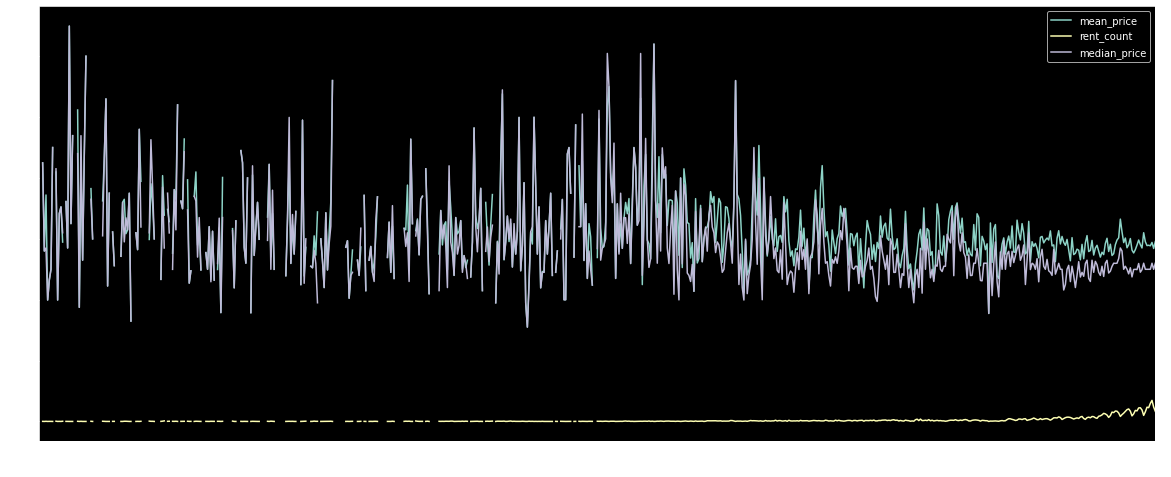

In [688]:
rent_ts.plot()


We need to fill in missing values. We use interpolation to do so

In [689]:
rent_ts = rent_ts.interpolate(method='spline', order=2)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


<AxesSubplot:>

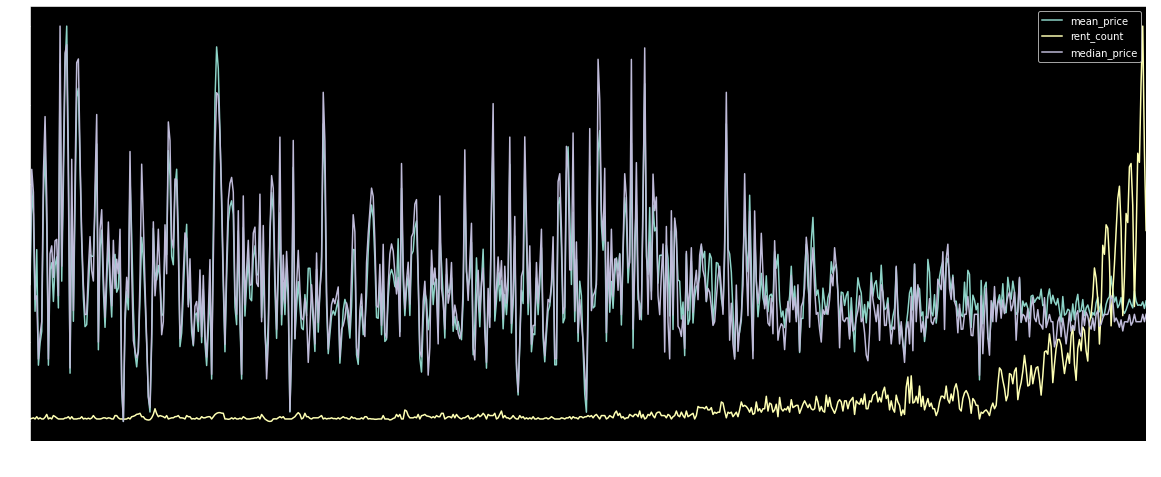

In [690]:
scaler = MinMaxScaler()
rent_ts = pd.DataFrame(scaler.fit_transform(rent_ts), index=rent_ts.index, columns=rent_ts.columns)
rent_ts.plot()

Now we need to smooth the data using a rolling window of 5 days and scale the data using min-max scaling.

We might need to use a trailing window because we are trying to forecast into the future.

Comparison between different smoothing options:

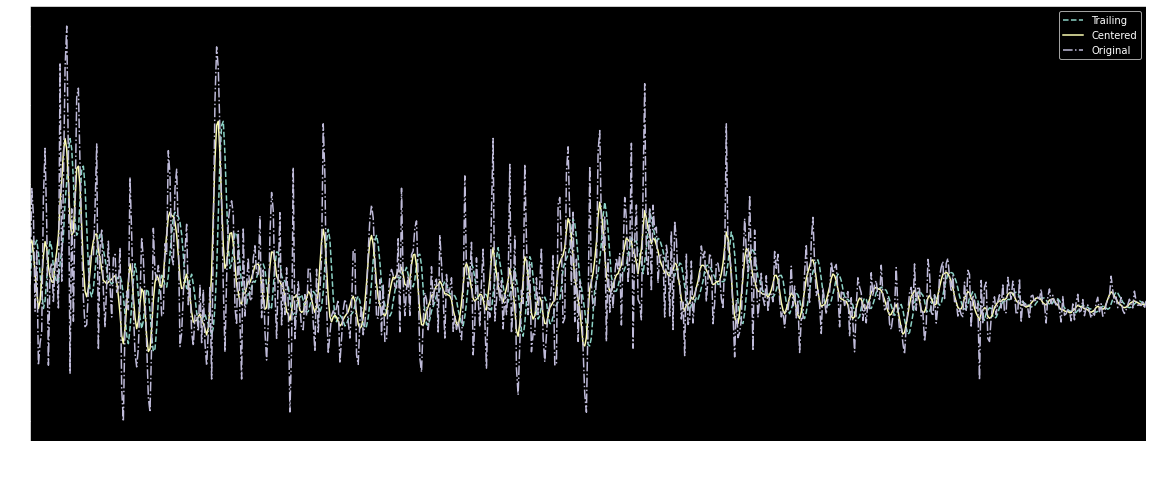

In [691]:
fig, ax = plt.subplots()
smoothed_ts = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1).mean()
smoothed_ts.plot(style='--', legend=True, ax=ax)
smoothed_ts_centered = rent_ts['mean_price'].rolling(7, win_type='triang', min_periods=1, center=True).mean()
smoothed_ts_centered.plot(legend=True, ax=ax)
smoothed_ts_not_smoothed = rent_ts['mean_price']
smoothed_ts_not_smoothed.plot(style='-.', legend=True, ax=ax)
ax.legend(["Trailing", "Centered", "Original"])


We also explore the price/sqr_feet

In [692]:
# we take the properties that actually have the area listed
price_sqft = rent_df[ ~rent_df['area'].isna() ].sort_values('date')
price_sqft['price_per_sqft'] = price_sqft['price']/price_sqft['area']

price_sqft = price_sqft.groupby(price_sqft.date)['price_per_sqft'].agg(['mean', 'median'])
price_sqft = price_sqft.rename({
    'mean': 'mean_price_per_sqft',
    'median': 'median_price_per_sqft'
}, axis=1)
price_sqft = price_sqft.reindex(idx)
price_sqft = price_sqft.interpolate(method='spline', order=2)
price_sqft = pd.DataFrame(scaler.fit_transform(price_sqft), index=price_sqft.index, columns=price_sqft.columns)
# price_sqft = price_sqft.rolling(7, win_type='triang', min_periods=1).mean()
rent_ts = pd.concat([rent_ts, price_sqft], axis=1)
rent_ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2019-06-01    0.346340    0.006219      0.383278                  NaN   
2019-06-02    0.589026    0.007559      0.637620                  NaN   
2019-06-03    0.523715    0.009091      0.579338             0.371368   
2019-06-04    0.278608    0.006219      0.308411             0.400047   
2019-06-05    0.434562    0.011963      0.317769             0.410451   
...                ...         ...           ...                  ...   
2021-03-28    0.294729    0.655336      0.252260             0.375550   
2021-03-29    0.293094    0.856390      0.252260             0.359170   
2021-03-30    0.302594    1.000000      0.270977             0.357571   
2021-03-31    0.285714    0.684058      0.252260             0.360774   
2021-04-01    0.304958    0.483004      0.270977             0.352941   

            median_price_per_sqft  
2019-06-01                    NaN  
2019-06-02                    NaN  
2019-06-03               0.371368  
2019-06-04               0.410469  
2019-06-05               0.418975  
...                           ...  
2021-03-28               0.349379  
2021-03-29               0.341482  
2021-03-30               0.354614  
2021-03-31               0.367309  
2021-04-01               0.345213  

[671 rows x 5 columns]

# Introducing COVID data

In [693]:
nyc_covid_df = pd.read_csv("data/covid/covid_nyc.csv")
nyc_covid_df.set_index("date", drop=True)
nyc_covid_df.drop(['city_pop2019', 'cityname', 'statename', 'statefips'], axis=1, inplace=True)
nyc_covid_df['date'] = pd.to_datetime(nyc_covid_df['date'])
nyc_covid_df = nyc_covid_df[(nyc_covid_df['date'] >= start) & (nyc_covid_df['date'] <= end)]
nyc_covid_ts = nyc_covid_df.set_index('date', drop=True)
nyc_covid_ts = nyc_covid_ts.rename({col: col + "_covid" for col in nyc_covid_ts.columns}, axis=1)

Covid raw data:

<AxesSubplot:xlabel='date'>

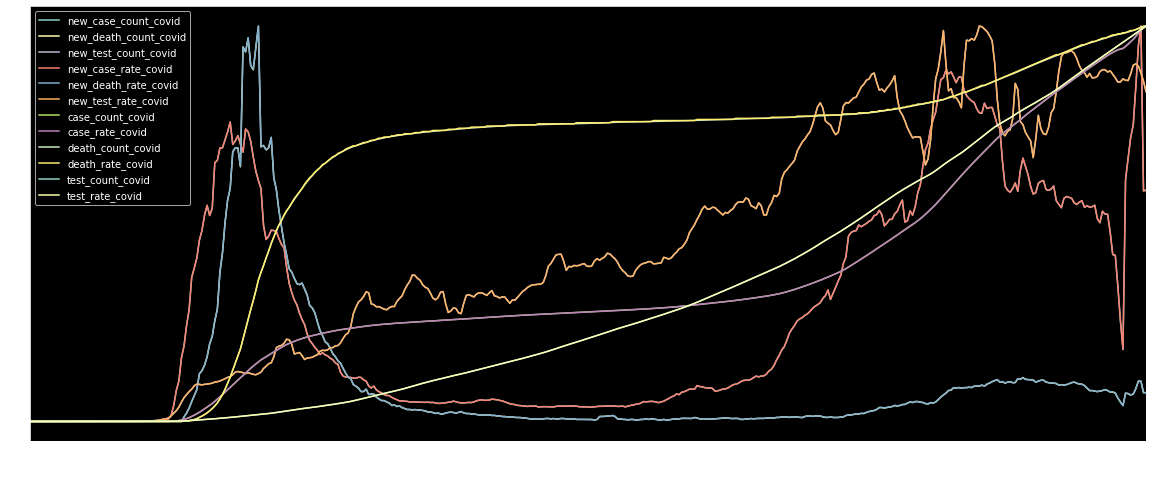

In [694]:
nyc_covid_ts = pd.DataFrame(scaler.fit_transform(nyc_covid_ts), columns=nyc_covid_ts.columns, index=nyc_covid_ts.index)
nyc_covid_ts.plot()


In [695]:
ts = pd.concat([rent_ts, nyc_covid_ts], axis=1)

In [696]:
ts

mean_price  rent_count  median_price  mean_price_per_sqft  \
2019-06-01    0.346340    0.006219      0.383278                  NaN   
2019-06-02    0.589026    0.007559      0.637620                  NaN   
2019-06-03    0.523715    0.009091      0.579338             0.371368   
2019-06-04    0.278608    0.006219      0.308411             0.400047   
2019-06-05    0.434562    0.011963      0.317769             0.410451   
...                ...         ...           ...                  ...   
2021-03-28    0.294729    0.655336      0.252260             0.375550   
2021-03-29    0.293094    0.856390      0.252260             0.359170   
2021-03-30    0.302594    1.000000      0.270977             0.357571   
2021-03-31    0.285714    0.684058      0.252260             0.360774   
2021-04-01    0.304958    0.483004      0.270977             0.352941   

            median_price_per_sqft  new_case_count_covid  \
2019-06-01                    NaN                   NaN   
2019-06-02                    NaN                   NaN   
2019-06-03               0.371368                   NaN   
2019-06-04               0.410469                   NaN   
2019-06-05               0.418975                   NaN   
...                           ...                   ...   
2021-03-28               0.349379              0.846034   
2021-03-29               0.341482              0.949766   
2021-03-30               0.354614              1.000000   
2021-03-31               0.367309              0.582801   
2021-04-01               0.345213              0.584930   

            new_death_count_covid  ...  new_test_rate_covid  case_count_covid  \
2019-06-01                    NaN  ...                  NaN               NaN   
2019-06-02                    NaN  ...                  NaN               NaN   
2019-06-03                    NaN  ...                  NaN               NaN   
2019-06-04                    NaN  ...                  NaN               NaN   
2019-06-05                    NaN  ...                  NaN               NaN   
...                           ...  ...                  ...               ...   
2021-03-28               0.083019  ...             0.904405          0.973731   
2021-03-29               0.101887  ...             0.898782          0.981735   
2021-03-30               0.101887  ...             0.880975          0.990161   
2021-03-31               0.072956  ...             0.860356          0.995072   
2021-04-01               0.072956  ...             0.834114          1.000000   

            case_rate_covid  death_count_covid  death_rate_covid  \
2019-06-01              NaN                NaN               NaN   
2019-06-02              NaN                NaN               NaN   
2019-06-03              NaN                NaN               NaN   
2019-06-04              NaN                NaN               NaN   
2019-06-05              NaN                NaN               NaN   
...                     ...                ...               ...   
2021-03-28         0.973781           0.990782          0.991667   
2021-03-29         0.981757           0.993477          0.994444   
2021-03-30         0.990131           0.996173          0.997222   
2021-03-31         0.995115           0.998070          1.000000   
2021-04-01         1.000000           1.000000          1.000000   

            test_count_covid  test_rate_covid  
2019-06-01               NaN              NaN  
2019-06-02               NaN              NaN  
2019-06-03               NaN              NaN  
2019-06-04               NaN              NaN  
2019-06-05               NaN              NaN  
...                      ...              ...  
2021-03-28          0.981962         0.981962  
2021-03-29          0.986629         0.986628  
2021-03-30          0.991204         0.991202  
2021-03-31          0.995669         0.995669  
2021-04-01          1.000000         1.000000  

[671 rows x 17 columns]

<AxesSubplot:>

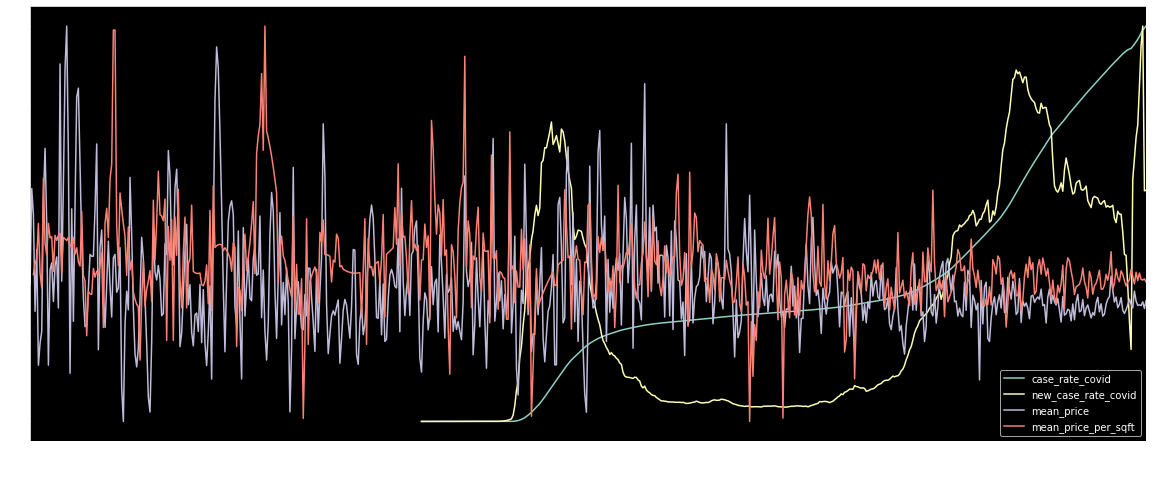

In [697]:
ts[['case_rate_covid', 'new_case_rate_covid', 'mean_price', 'mean_price_per_sqft']].plot()

# Seasonal Decompositions
Decomposition is the process of understanding generalizations and problems related to time-series forecasting.
We can leverage seasonal decomposition to remove seasonality from data and check the data only with the trend,
cyclic, and irregular variations.

First we explore the decompositions of COVID time series

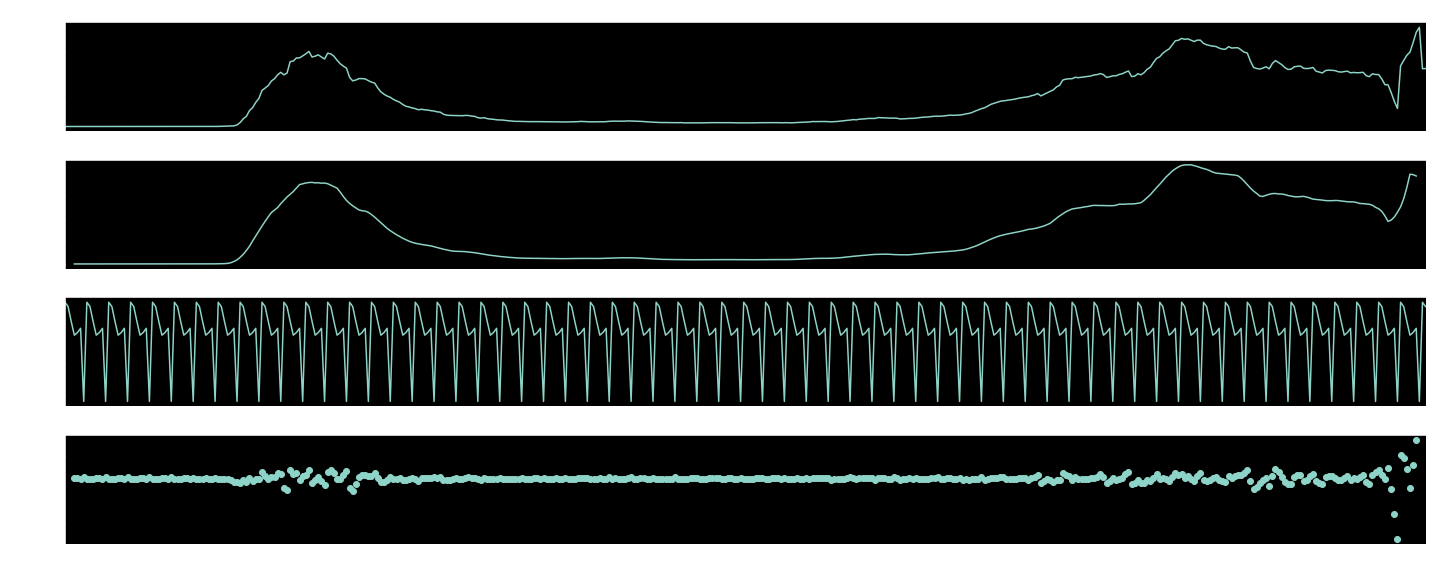

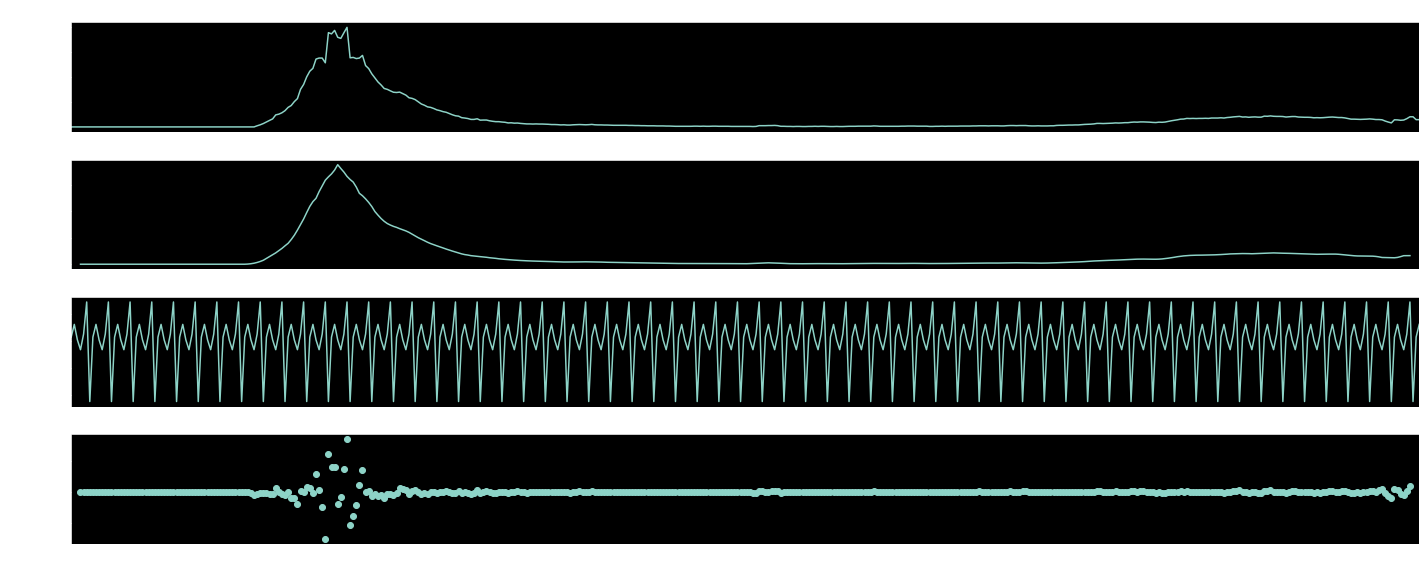

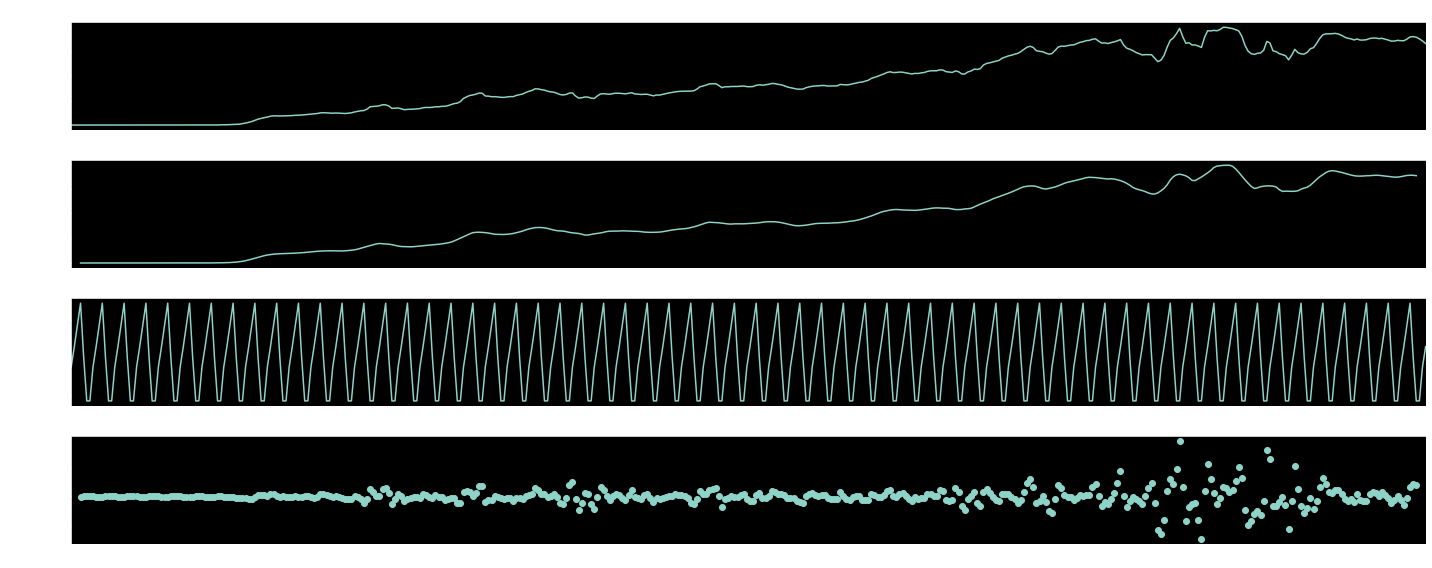

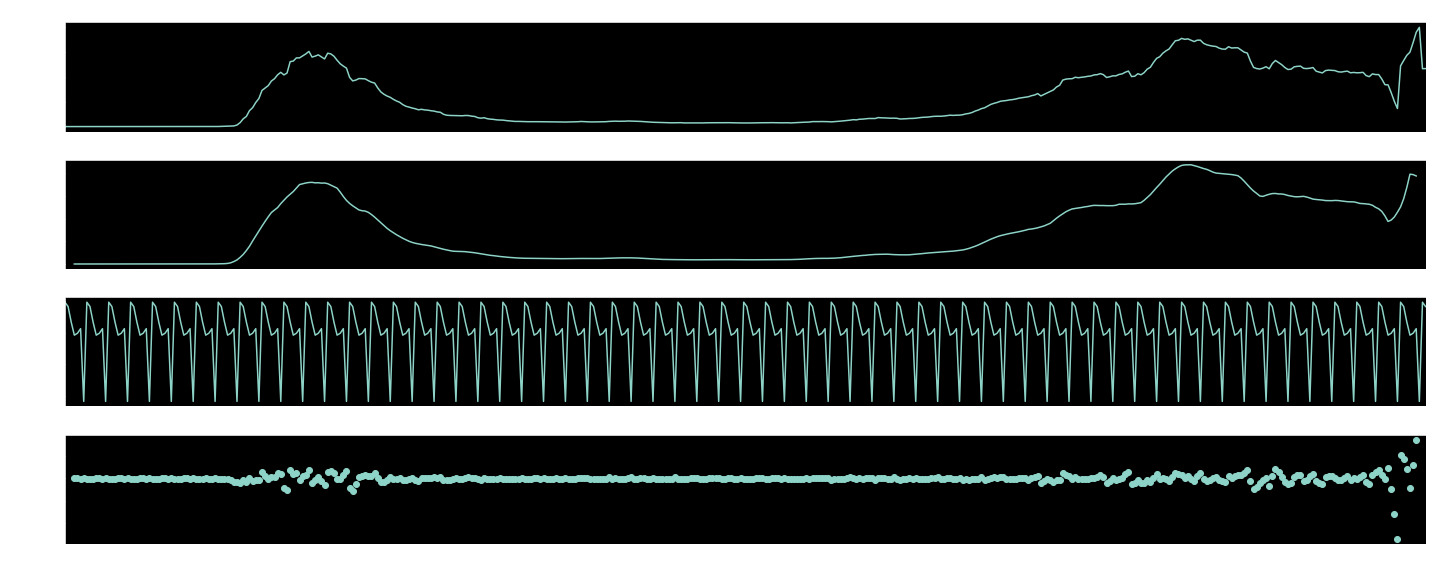

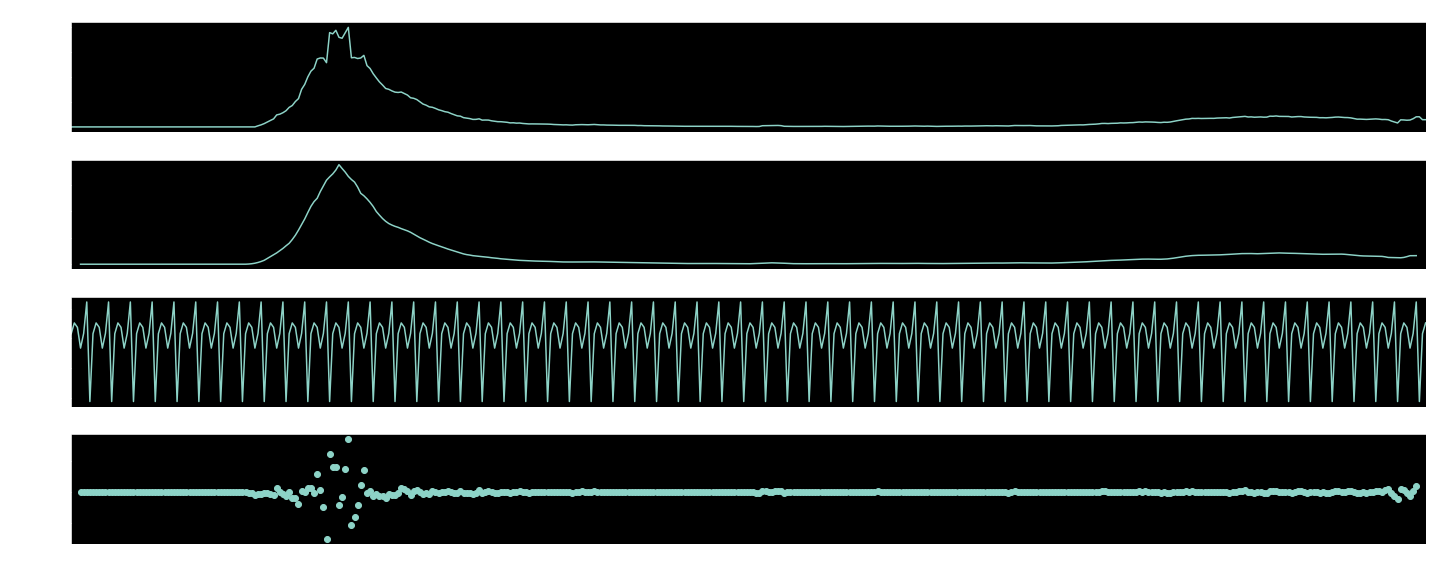

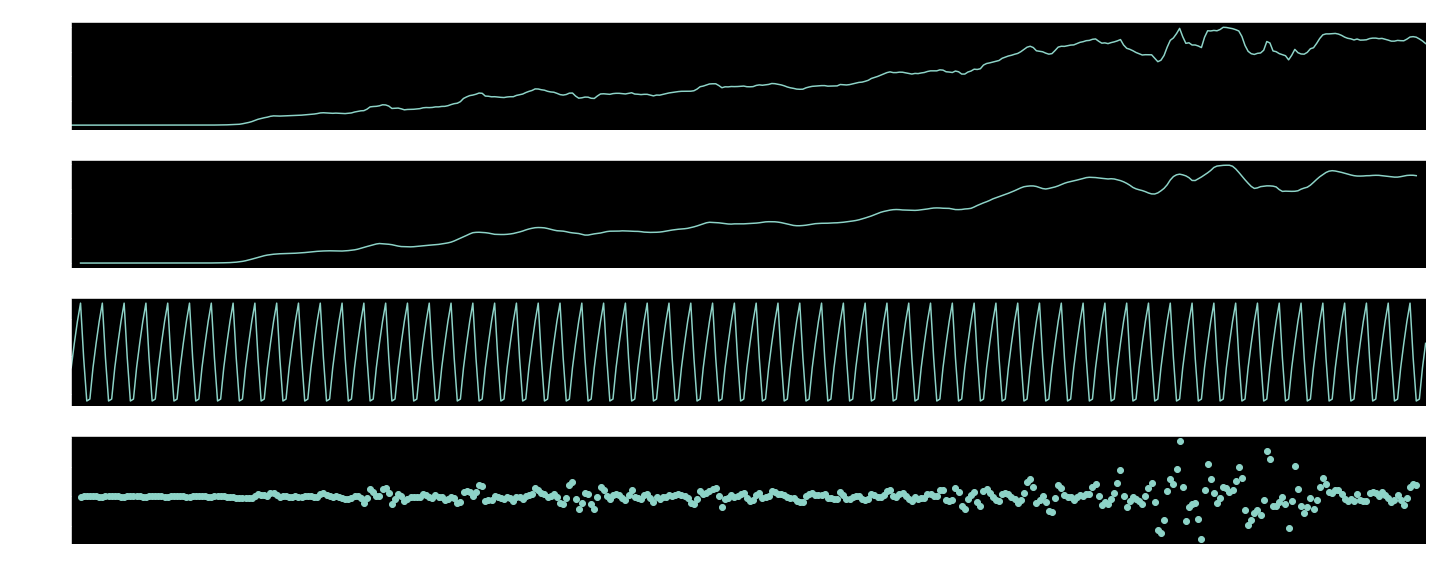

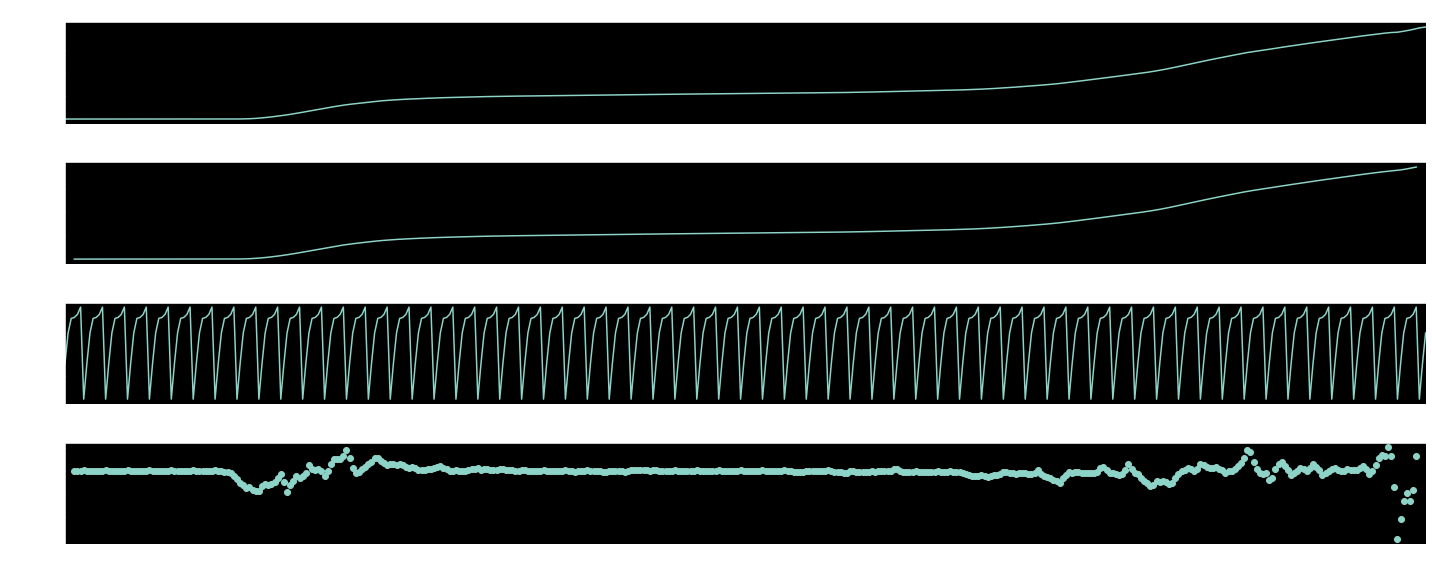

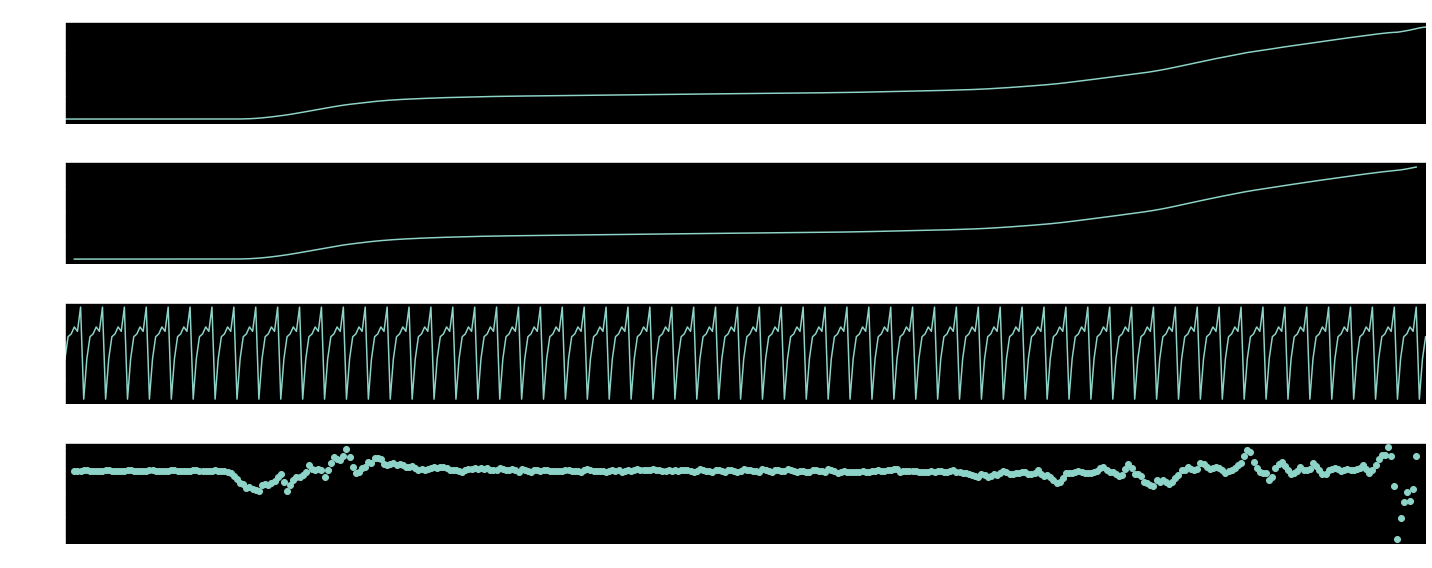

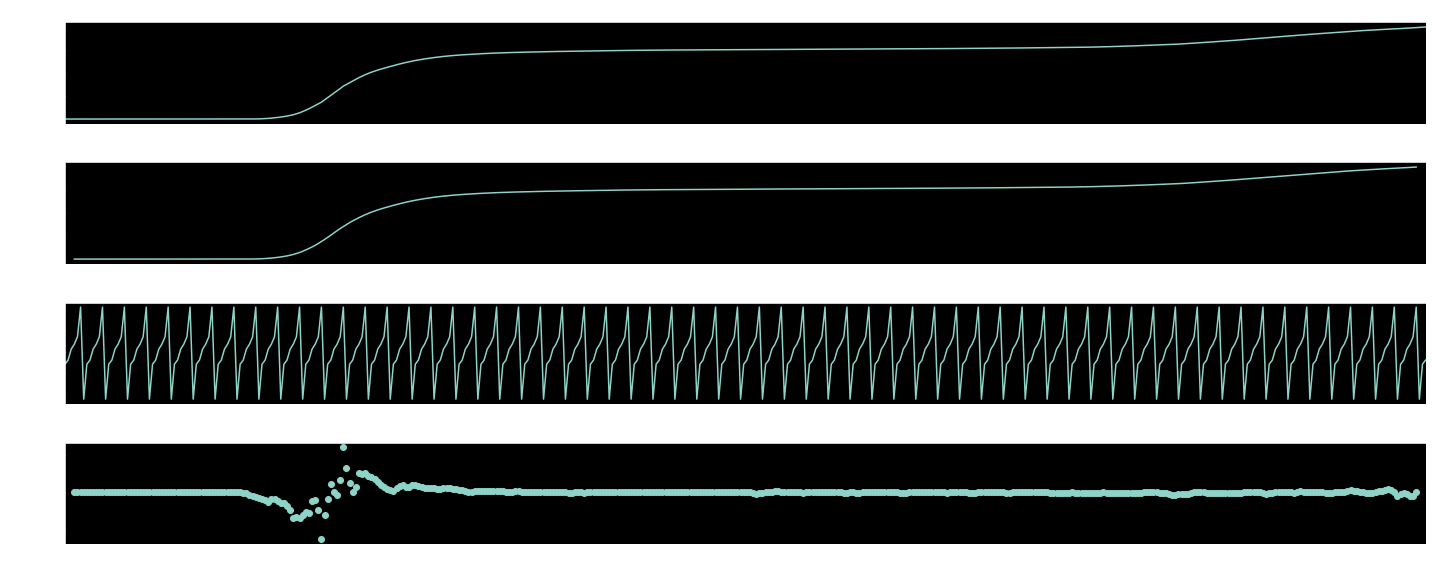

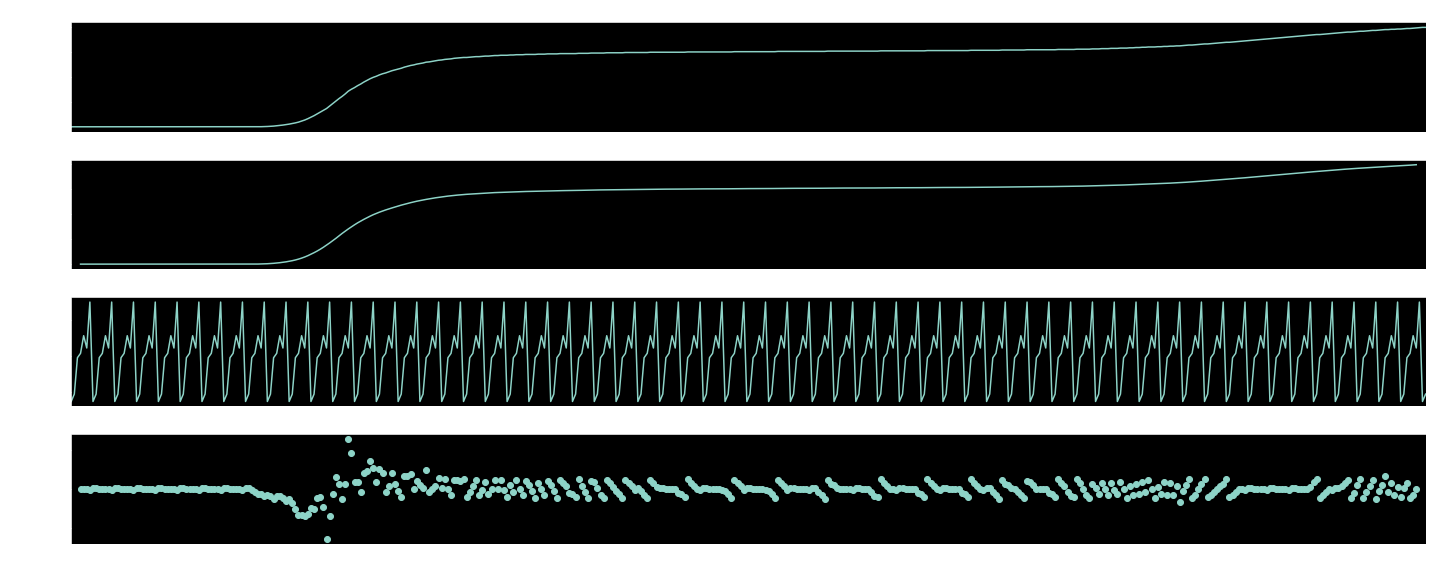

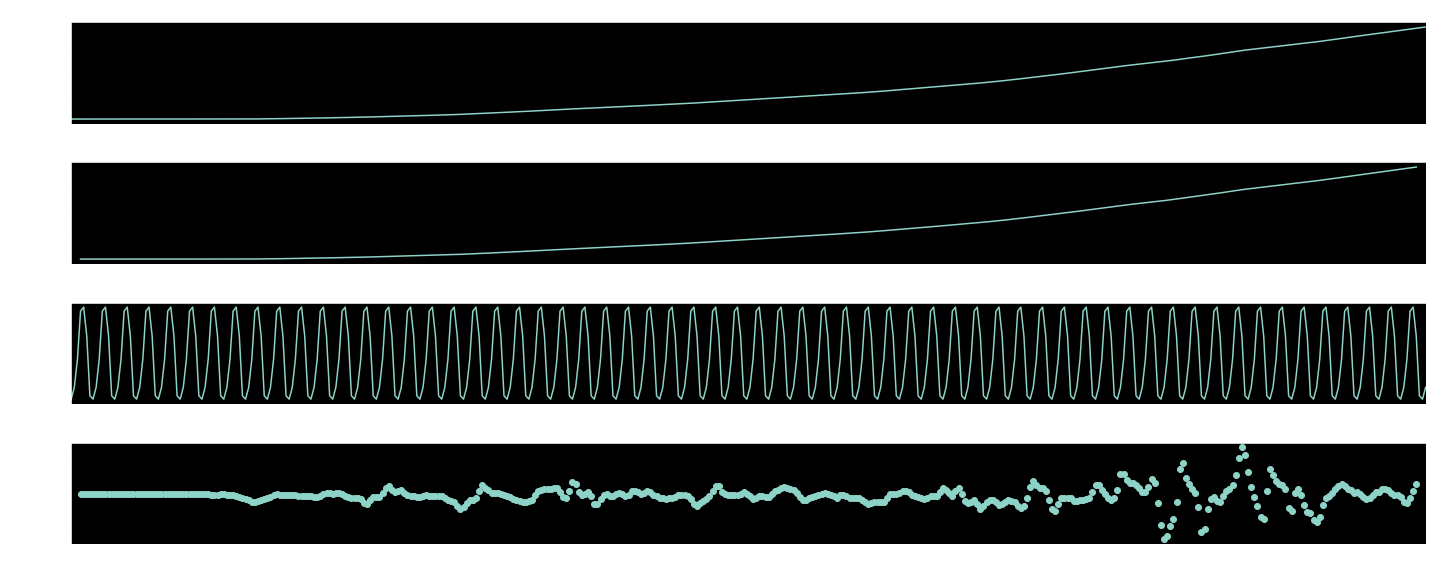

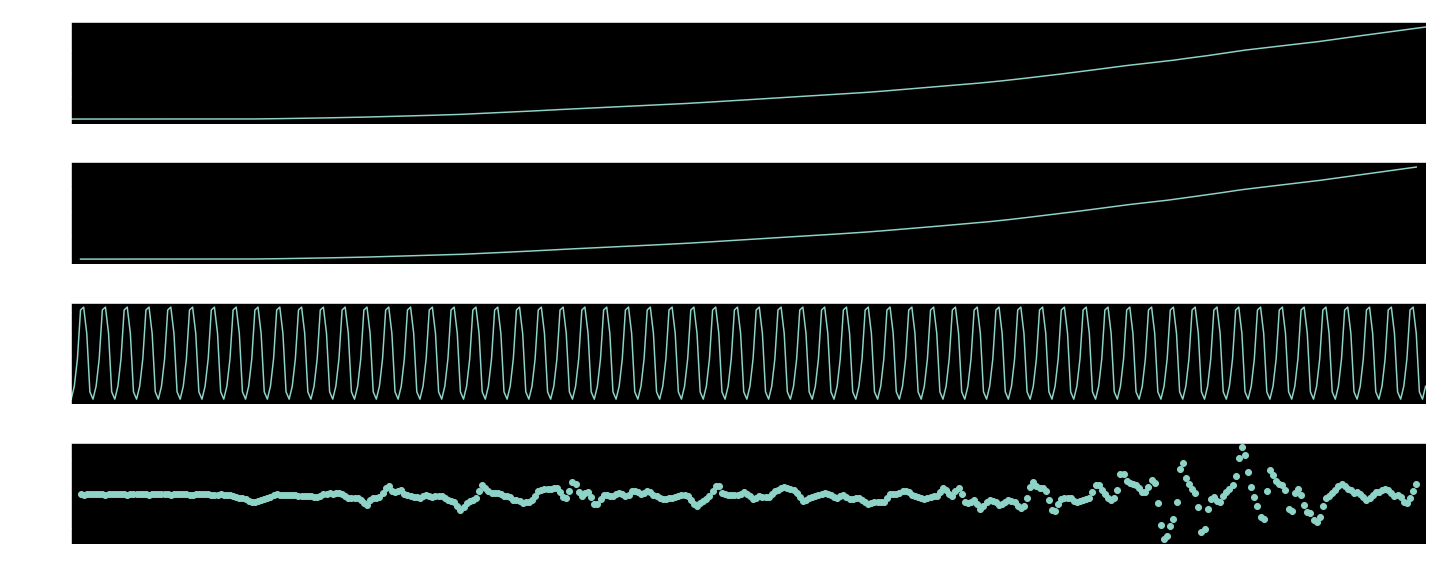

In [698]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals = dict()


legend = []
for col in ts.columns:
    if 'covid' in col:
        legend.append(col)
        covid_df = ts[col]
        covid_decomposition = seasonal_decompose(covid_df.drop(covid_df[covid_df.isna()].index), model='additive')
        residuals[col+'_resid'] = covid_decomposition.resid
        covid_decomposition.plot()

residuals_ts = pd.concat(residuals, axis=1)

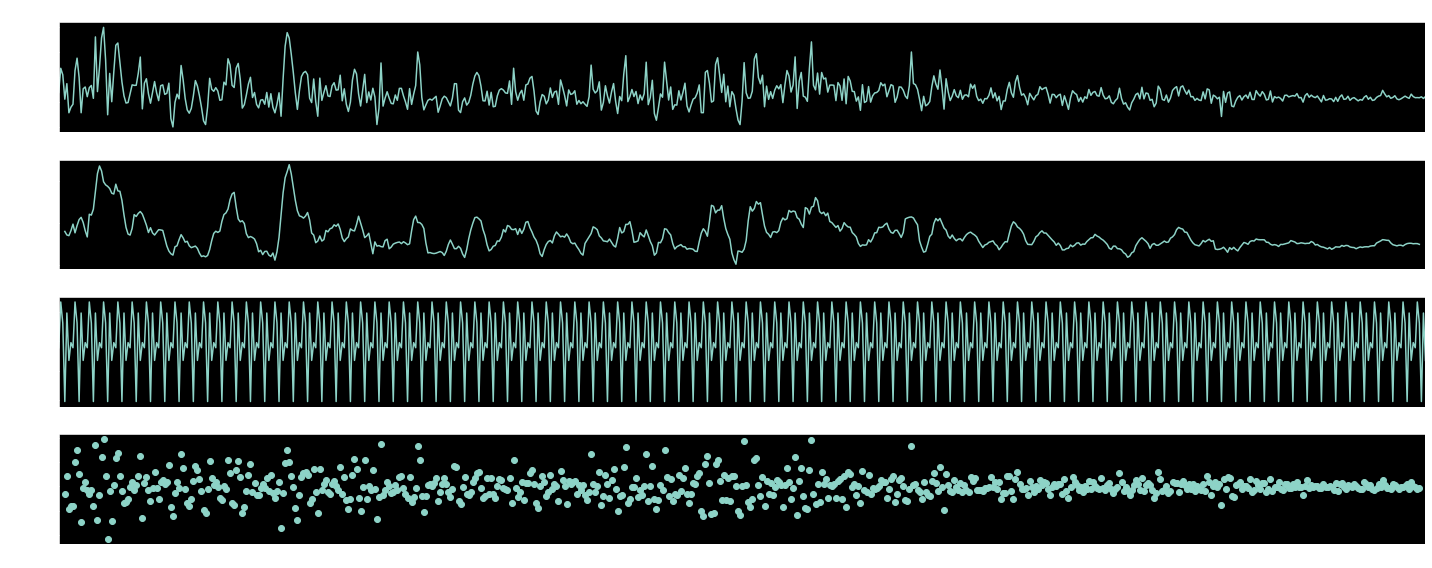

In [699]:
price = ts['mean_price']
price_decomposition = seasonal_decompose(price.drop(price[price.isna()].index), model='additive')
price_decomposition.plot()
plt.show()

In [700]:
ts = pd.concat([ts, residuals_ts, price_decomposition.resid.rename({'resid': 'mean_price_resid' }, axis=1)], axis=1)

<AxesSubplot:>

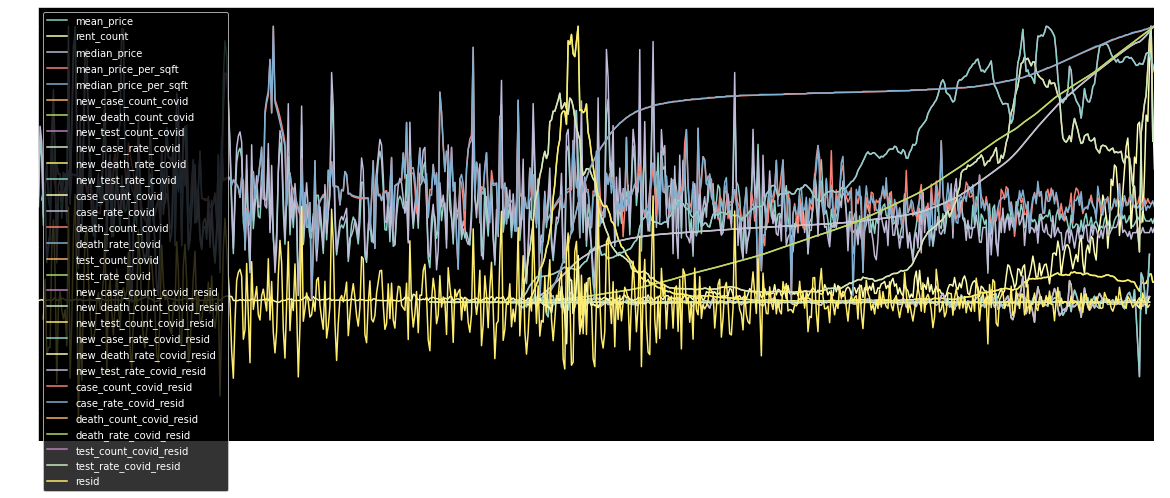

In [701]:
ts.plot()

# Autocorrelation plots
Autocorrelation is used to check randomness in data. It helps to identify types of data where the period is not known.

https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show]

# covid case rate autocorrelation plot:

Ploting the PACF and ACF of case rate

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))
/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a ne

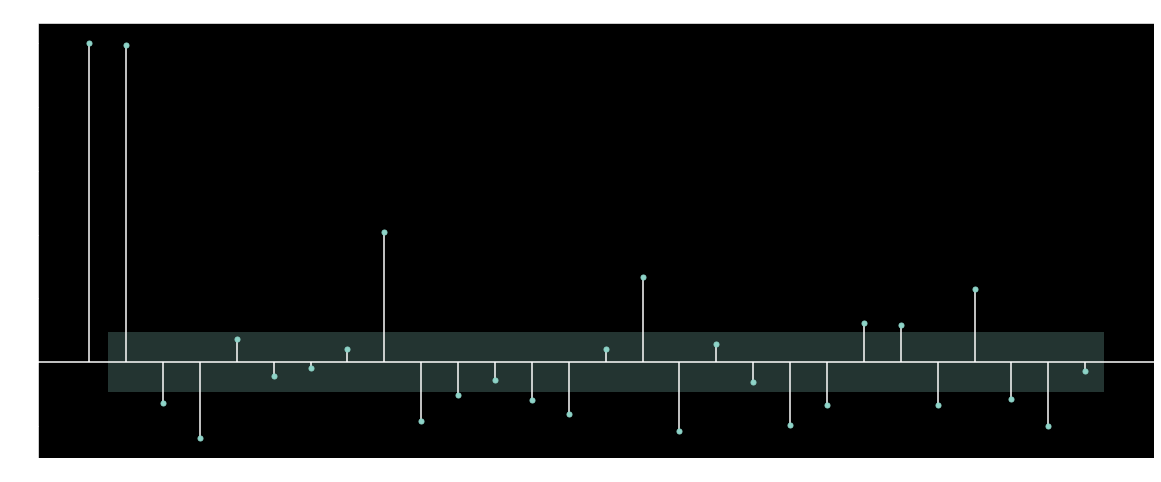

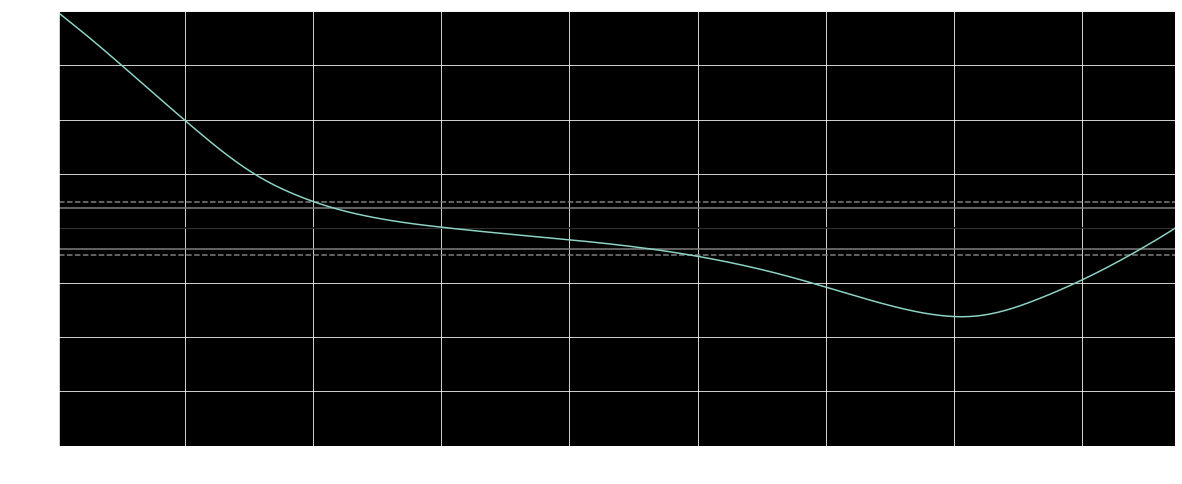

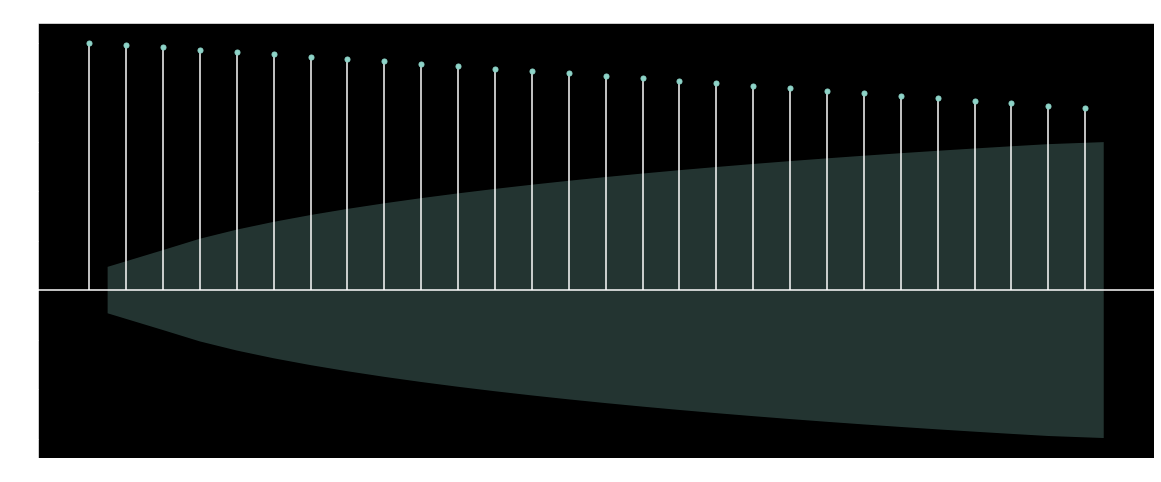

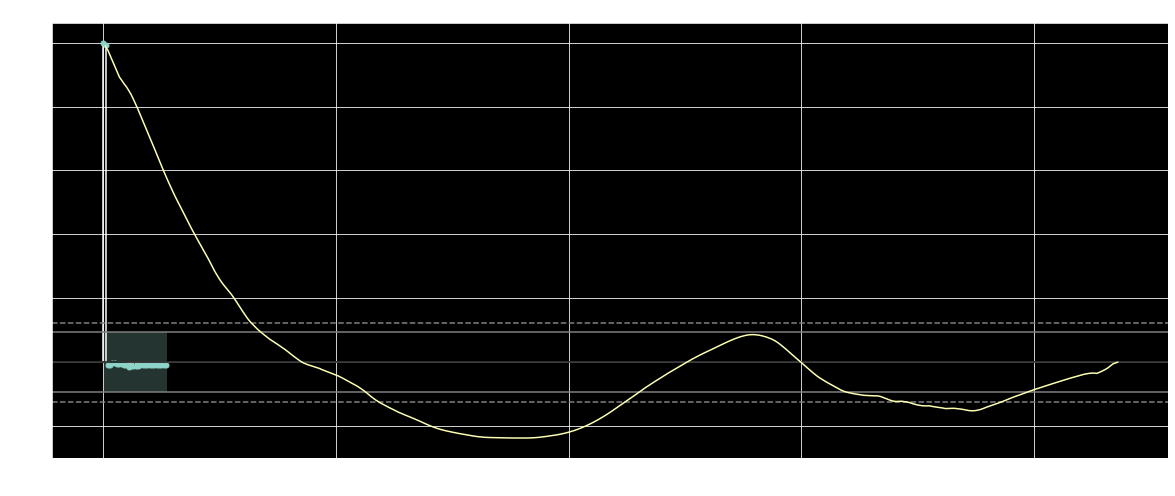

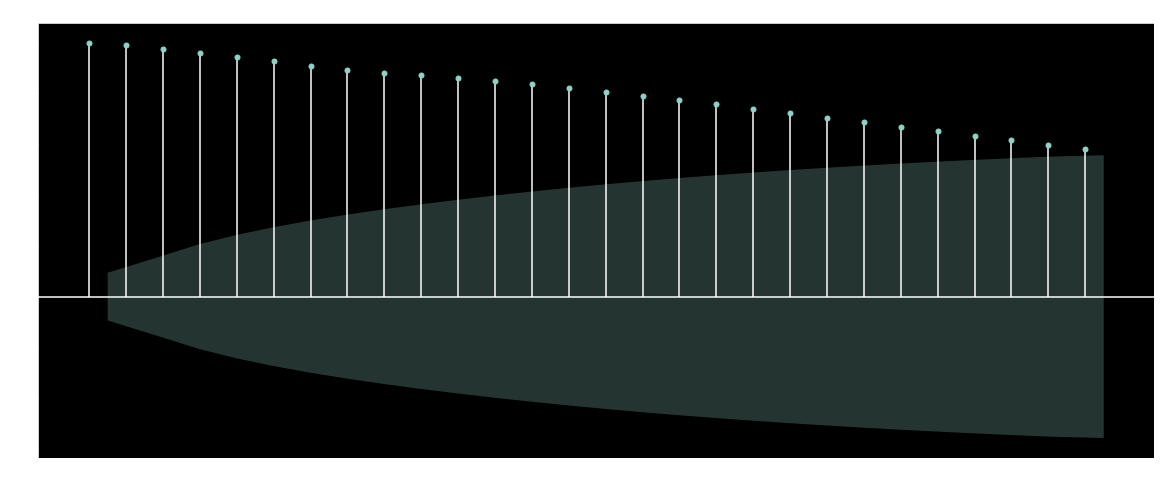

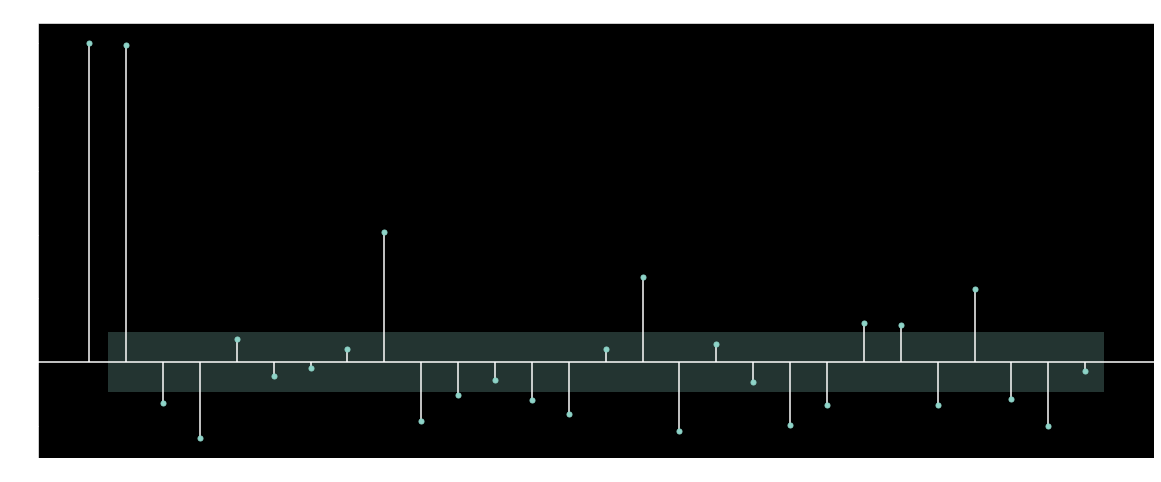

In [702]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

case_rate = ts[~ts['case_rate_covid'].isna()]['case_rate_covid']
autocorrelation_plot(case_rate.tolist())
plot_acf(case_rate)
plot_pacf(case_rate)

new_case_rate = ts[~ts['new_case_rate_covid'].isna()]['new_case_rate_covid']
autocorrelation_plot(new_case_rate.tolist())
plot_acf(new_case_rate)
plot_pacf(new_case_rate)

Ploting the PACF and ACF of mean price and number of properties for rent

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


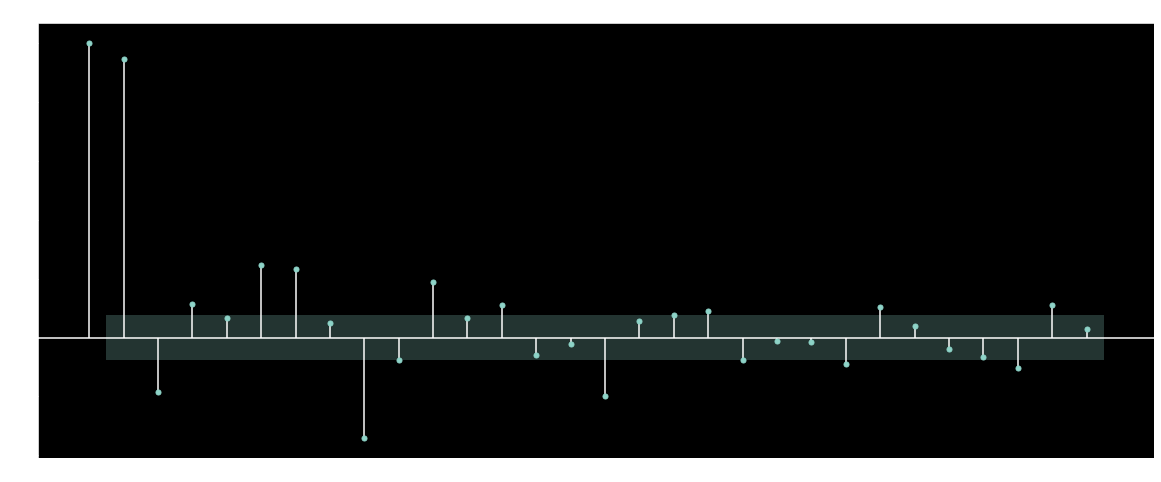

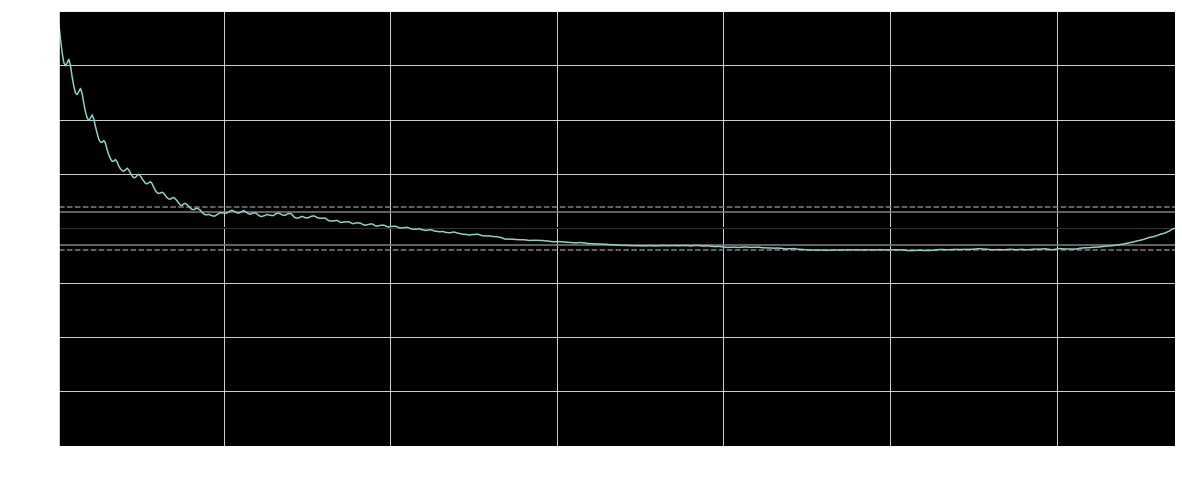

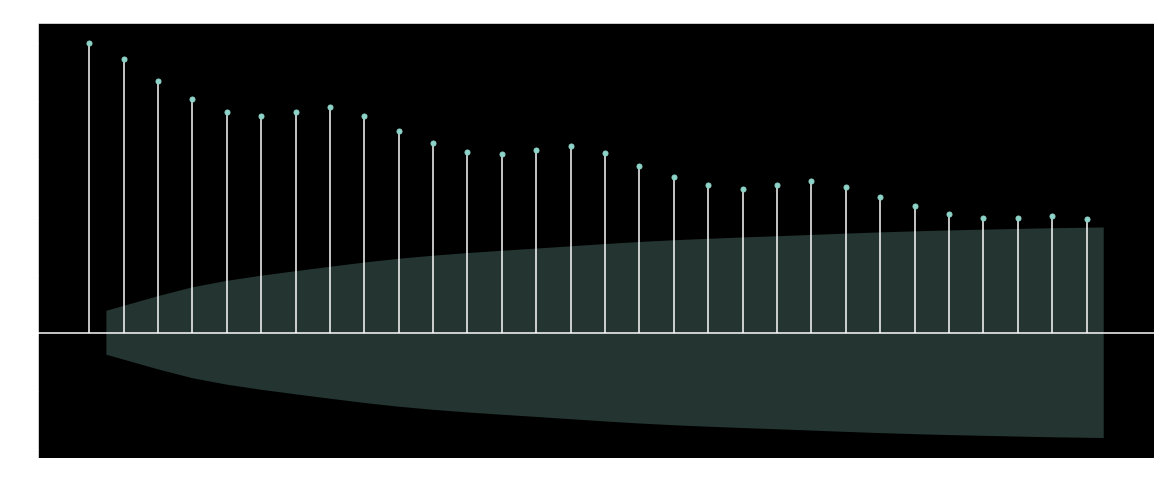

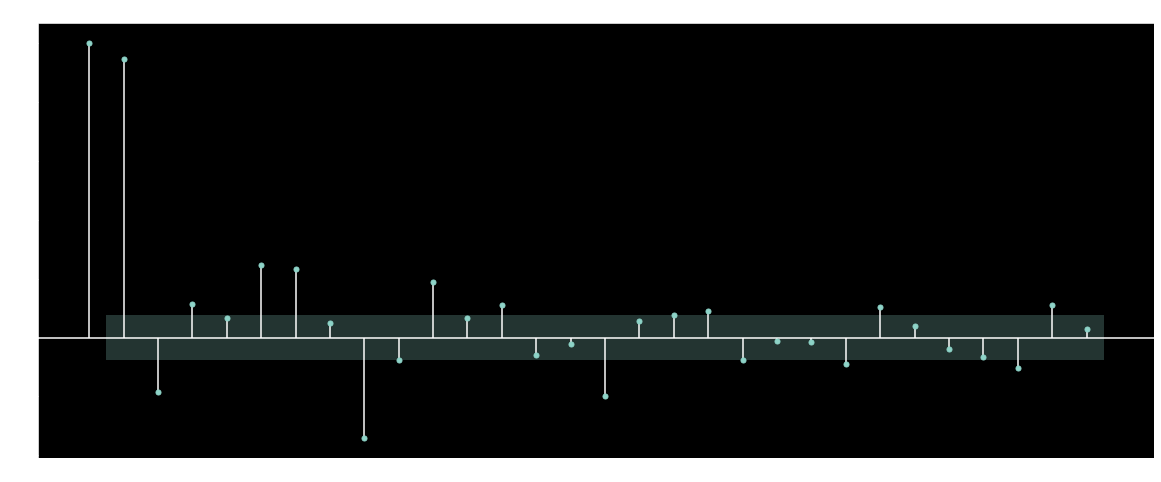

In [703]:
count = ts[~ts['rent_count'].isna()]['rent_count']
autocorrelation_plot(count)
plot_acf(count)
plot_pacf(count)

/Users/tomasortega/Desktop/projects/BDS_project/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


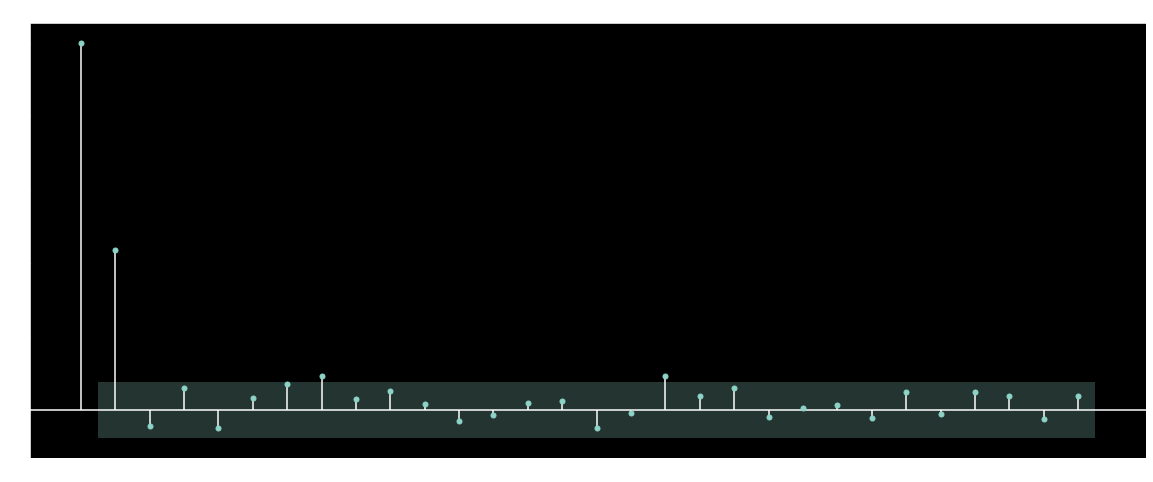

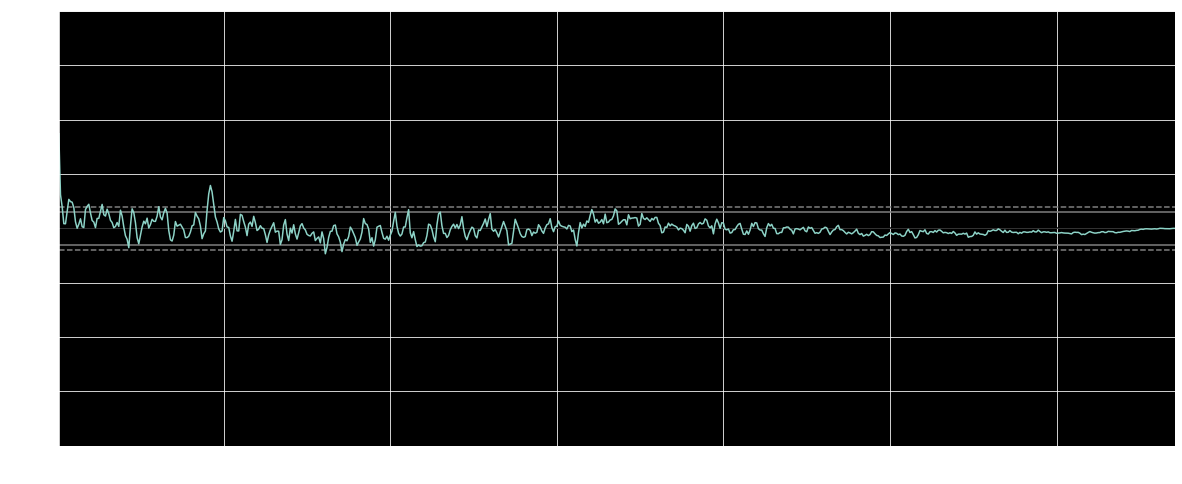

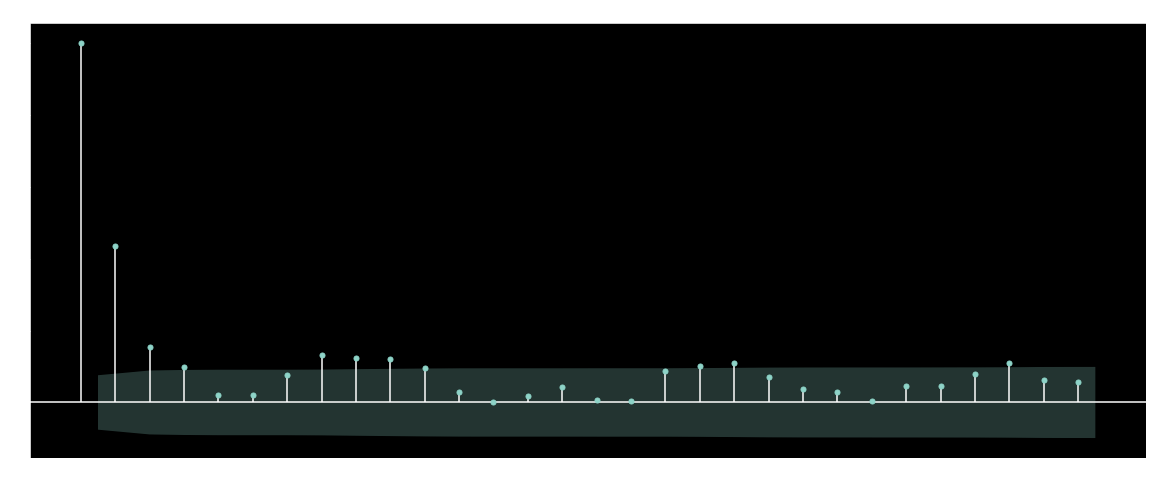

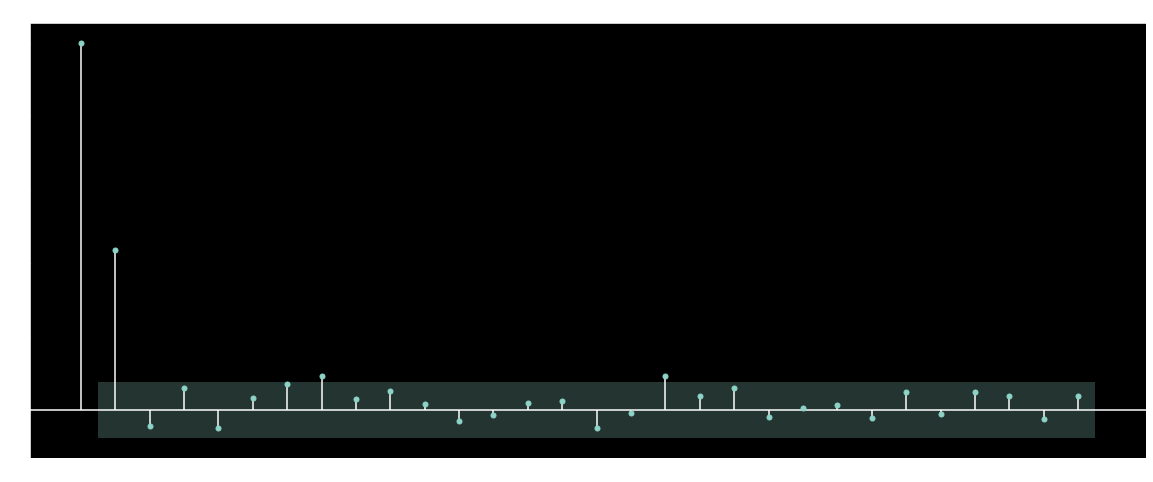

In [704]:
mean_price = ts[~ts['mean_price'].isna()]['mean_price']
autocorrelation_plot(mean_price)
plot_acf(mean_price)
plot_pacf(mean_price)

# Cross Correlation

The first plot shows the correlation with a forward lag

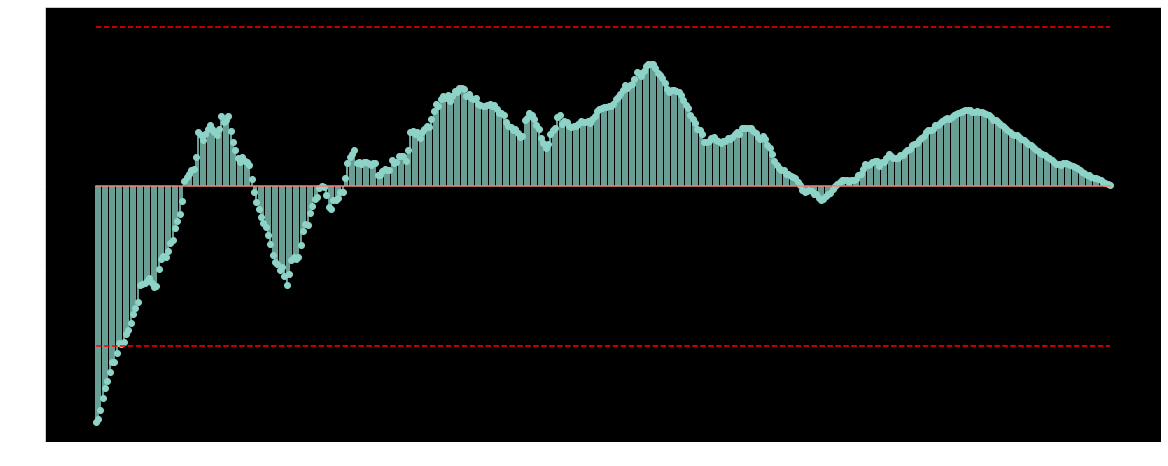

In [705]:
# correlation using just ccf and then plotting with custom function
from math import sqrt
from statsmodels.tsa.stattools import ccf

y = new_case_rate
x = mean_price[(ts.index >= y.index.min()) & (mean_price.index <= y.index.max())]

cross_correlation = ccf(x, y, adjusted=False)
plt.stem(cross_correlation)
ci = 2*(1/sqrt(len(x)))
plt.plot([i for i in range(len(cross_correlation))], [ci]*len(cross_correlation), color='r', ls="--")
plt.plot([i for i in range(len(cross_correlation))], [-1*ci]*len(cross_correlation), color='r', ls="--")
plt.show()

Now we show the correlation with forward and backwards lag

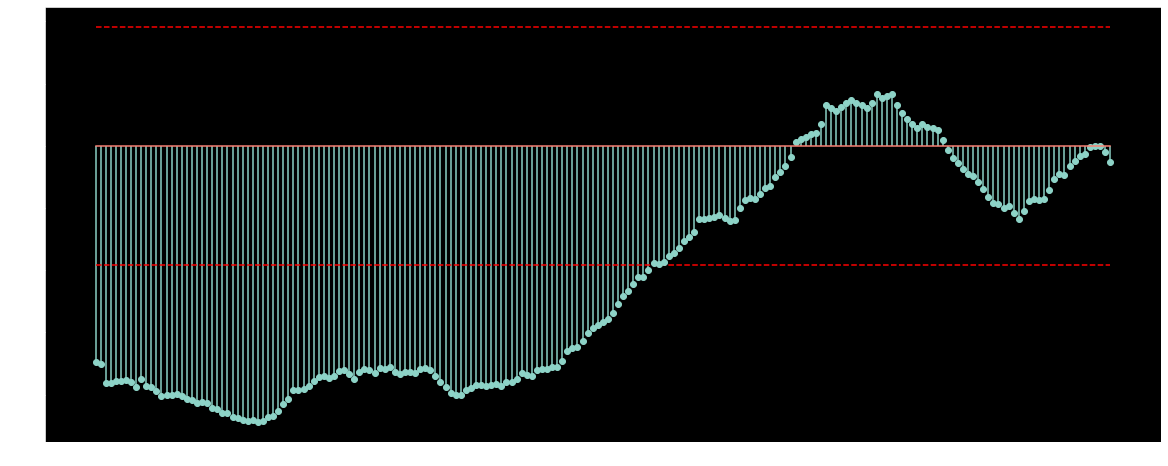

In [706]:
def ccorr_plot(x, y, values=20):
    # this function plots the cross correlation plot with positive and negative lags
    backwards = ccf(x[::-1], y[::-1], adjusted=False)[::-1][(-1*(values+1)):]
    forwards = ccf(x,y, adjusted=False)[:(values+1)]
    ccf_output = np.r_[backwards[:-1], forwards]  # we need the [:-1] because we have a duplicate for lag=0
    x_axis = list(range(-1*values, values+1))
    ci = 2*(1/sqrt(len(x)))
    plt.plot(x_axis, [ci]*len(x_axis), color='r', ls="--")
    plt.plot(x_axis, [-1*ci]*len(x_axis), color='r', ls="--")
    plt.stem(x_axis, ccf_output)
    plt.show()

ccorr_plot(x, y, 100)

# Time Series with lag

A negative value for h (lag) is a correlation between the x-variable at a time before t (the current time) and the y-variable at time t.
if h = -2 then the ccf value would give the correlation between x<sub>t-2</sub> and y<sub>t</sub>.

* if x<sub>t+h</sub> with h __negative__, is a predictor of y<sub>t</sub>, it is said that x __leads__ y.
* if x<sub>t+h</sub> with h __positive__, is a predictor of y<sub>t</sub>, it is said that x __lags__ y.

In some problems, the goal may be to identify which variable is leading and which is lagging.
In many problems we consider, though, we’ll examine the x-variable(s) to be a leading variable
of the y-variable because we will want to use values of the x-variable to predict future values of y.

I think in this case because our x is real estate and our y is covid and h is negative we can say that real estate leads covid in some weird way.
This is not what we wanted to show but it is the result we are getting.

<AxesSubplot:>

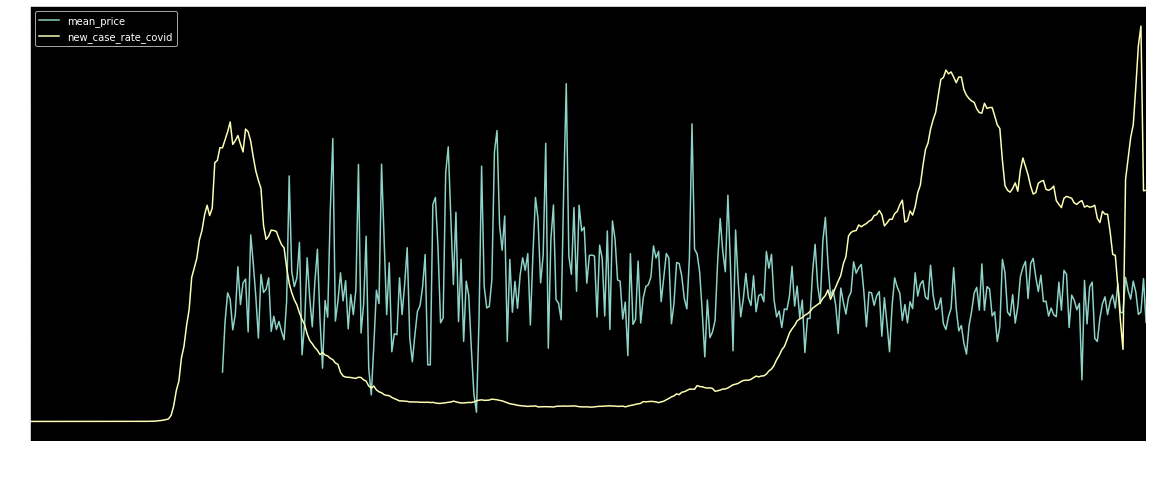

In [707]:
# x = pd.DataFrame(scaler.fit_transform(np.array(x.tolist()).reshape(-1, 1)), index=x.index)
# y  = pd.DataFrame(scaler.fit_transform(np.array(y.tolist()).reshape(-1, 1)), index=y.index)
df = pd.concat([x.shift(75), y], axis=1)
df.plot()

In [708]:
ts.corr()

mean_price  rent_count  median_price  \
mean_price                 1.000000   -0.113812      0.934431   
rent_count                -0.113812    1.000000     -0.194213   
median_price               0.934431   -0.194213      1.000000   
mean_price_per_sqft        0.233053   -0.128414      0.260194   
median_price_per_sqft      0.247016   -0.139678      0.277881   
...                             ...         ...           ...   
death_count_covid_resid    0.059194   -0.000697      0.017549   
death_rate_covid_resid    -0.016142   -0.029772     -0.039977   
test_count_covid_resid    -0.004769    0.050076     -0.016888   
test_rate_covid_resid     -0.004955    0.049936     -0.016928   
resid                      0.830616    0.001182      0.766085   

                         mean_price_per_sqft  median_price_per_sqft  \
mean_price                          0.233053               0.247016   
rent_count                         -0.128414              -0.139678   
median_price                        0.260194               0.277881   
mean_price_per_sqft                 1.000000               0.972616   
median_price_per_sqft               0.972616               1.000000   
...                                      ...                    ...   
death_count_covid_resid             0.076358               0.064906   
death_rate_covid_resid              0.027914               0.022053   
test_count_covid_resid              0.077755               0.074776   
test_rate_covid_resid               0.077640               0.074785   
resid                               0.148362               0.155217   

                         new_case_count_covid  new_death_count_covid  ...  \
mean_price                          -0.141411               0.119049  ...   
rent_count                           0.464679              -0.054207  ...   
median_price                        -0.156801               0.188303  ...   
mean_price_per_sqft                 -0.152121               0.044125  ...   
median_price_per_sqft               -0.143259               0.054235  ...   
...                                       ...                    ...  ...   
death_count_covid_resid             -0.164940               0.060769  ...   
death_rate_covid_resid              -0.126815               0.042195  ...   
test_count_covid_resid               0.025321               0.003529  ...   
test_rate_covid_resid                0.025413               0.003531  ...   
resid                               -0.002770               0.009557  ...   

                         case_count_covid_resid  case_rate_covid_resid  \
mean_price                             0.075189               0.078256   
rent_count                            -0.146623              -0.147306   
median_price                           0.065524               0.070313   
mean_price_per_sqft                    0.085500               0.083634   
median_price_per_sqft                  0.098062               0.096016   
...                                         ...                    ...   
death_count_covid_resid                0.340871               0.338601   
death_rate_covid_resid                 0.261716               0.266951   
test_count_covid_resid                 0.175630               0.170998   
test_rate_covid_resid                  0.176102               0.171496   
resid                                 -0.021504              -0.018052   

                         death_count_covid_resid  death_rate_covid_resid  \
mean_price                              0.059194               -0.016142   
rent_count                             -0.000697               -0.029772   
median_price                            0.017549               -0.039977   
mean_price_per_sqft                     0.076358                0.027914   
median_price_per_sqft                   0.064906                0.022053   
...                                          ...                     ...   
death_count_covid_resid                 1.000

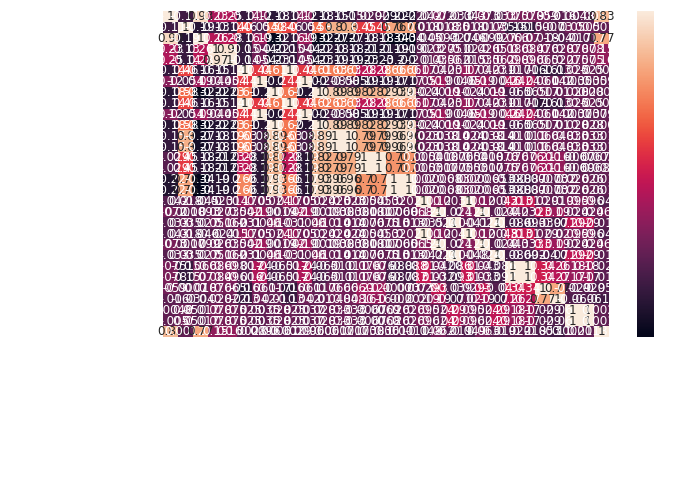

In [709]:
import seaborn as sns
corr = ts.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [710]:
# TODO: remove seasonality and apply diff


I think there is no seasonality in the real estate data but there seems to be seasons in the case-rate of covid 
but I need to do more research on this.

# Stationary Behavior
Stationary data means that the statistical properties of the particular process (mean and variance) do not vary with time.
Most TS models work on the assumption that the TS is stationary.

To test for stationarity we can use the Dickey-Fuller test. In this test the null hypothesis is that the Time series is non-stationary.
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.
If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that
the series is stationary.

In [711]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_test(df):
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [712]:
print("COVID Results of Dicke-Fuller Test:")
dickey_fuller_test(case_rate)

COVID Results of Dicke-Fuller Test:
Test Statistic                   1.475658
p-value                          0.997432
#Lags Used                      15.000000
Number of Observations Used    420.000000
Critical Value (1%)             -3.446016
Critical Value (5%)             -2.868446
Critical Value (10%)            -2.570449
dtype: float64


It seems that we can't reject the null hypothesis in the case of COVID case-rate

In [713]:
print("Rent Results of Dicke-Fuller Test:")
dickey_fuller_test(mean_price)

Rent Results of Dicke-Fuller Test:
Test Statistic                -7.417139e+00
p-value                        6.887884e-11
#Lags Used                     6.000000e+00
Number of Observations Used    6.640000e+02
Critical Value (1%)           -3.440237e+00
Critical Value (5%)           -2.865903e+00
Critical Value (10%)          -2.569093e+00
dtype: float64


In the case of mean rent prices it seems that we can reject the null hypothesis and say that the time series is stationary

## Making COVID TS stationary
I think we can use the results from the decomposition that we got earlier and get the residual

In [714]:
test = ts['case_rate_covid_resid'][~ts['case_rate_covid_resid'].isna()]

Test Statistic                  -3.608514
p-value                          0.005600
#Lags Used                      13.000000
Number of Observations Used    416.000000
Critical Value (1%)             -3.446168
Critical Value (5%)             -2.868513
Critical Value (10%)            -2.570484
dtype: float64


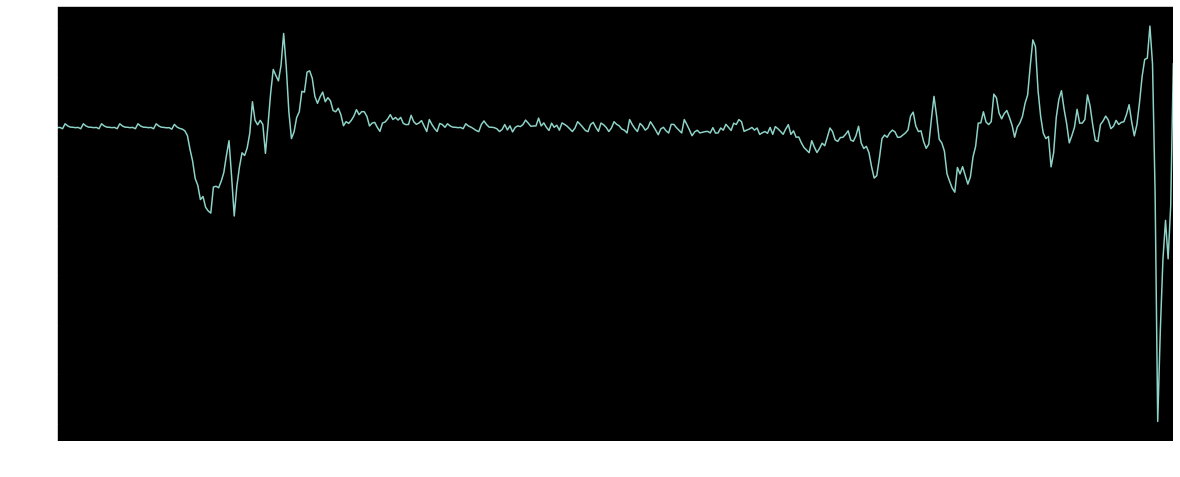

In [715]:
test.plot()
dickey_fuller_test(test)
# result_covid.plot()#%%

In [716]:
x = ts['resid'][(ts['resid'].index >= y.index.min()) & (ts['resid'].index <= y.index.max())].dropna()
x

2020-01-22   -0.175892
2020-01-23    0.006614
2020-01-24    0.086658
2020-01-25    0.038817
2020-01-26   -0.078043
                ...   
2021-03-25    0.033753
2021-03-26    0.005051
2021-03-27   -0.004883
2021-03-28   -0.019226
2021-03-29   -0.010204
Freq: D, Name: resid, Length: 433, dtype: float64

<AxesSubplot:>

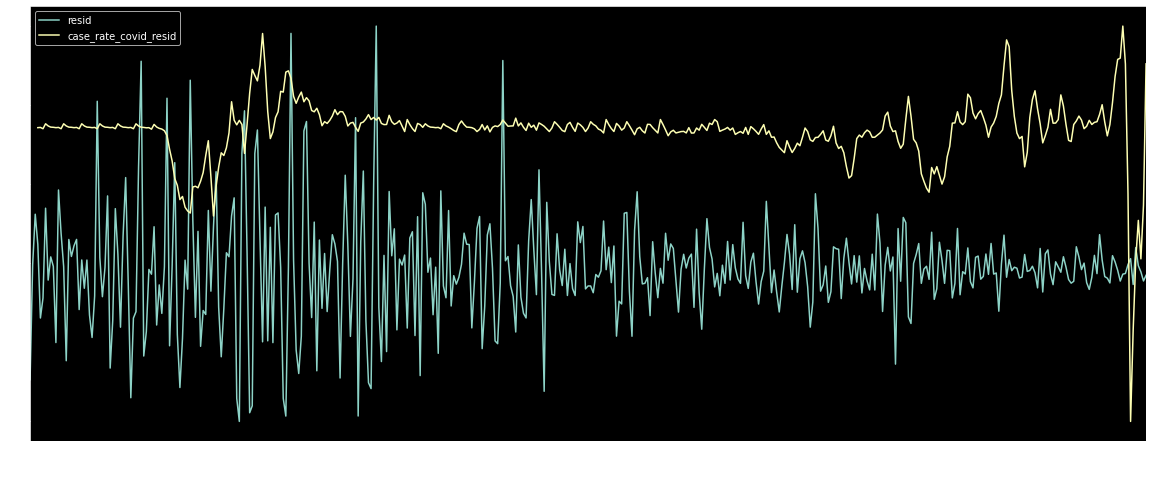

In [717]:
df = pd.concat([x, test], axis=1)
df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
df.plot()

In [718]:
df

resid  case_rate_covid_resid
2020-01-22  0.105628                    NaN
2020-01-23  0.396511                    NaN
2020-01-24  0.524087                    NaN
2020-01-25  0.447836               0.743085
2020-01-26  0.261582               0.743683
...              ...                    ...
2021-03-25  0.439765               0.409001
2021-03-26  0.394020               0.508526
2021-03-27  0.378186               0.411236
2021-03-28  0.355327               0.547429
2021-03-29  0.369705               0.904526

[433 rows x 2 columns]

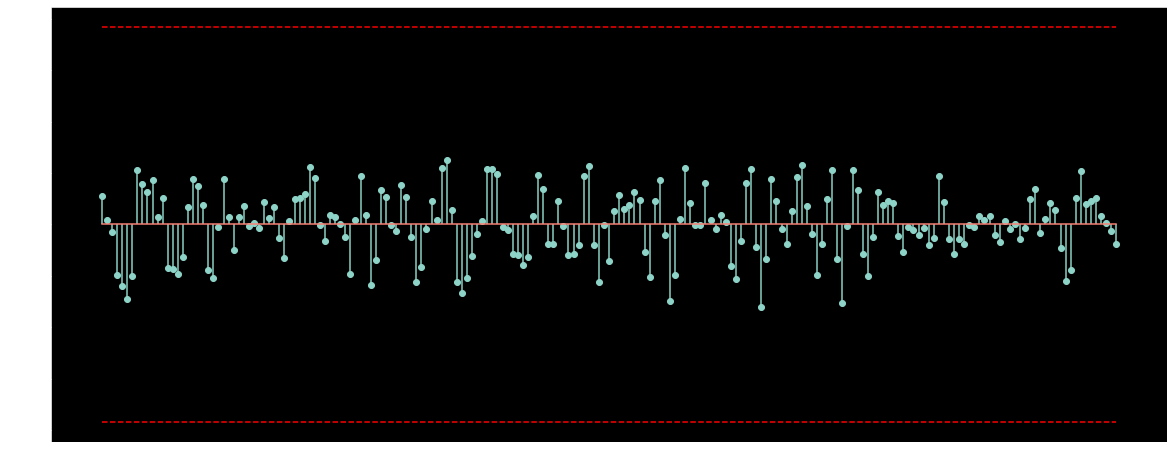

In [719]:
ccorr_plot(df['resid'].dropna(), df['case_rate_covid_resid'].dropna(), 100)

In [720]:
df.corr()

resid  case_rate_covid_resid
resid                  1.000000              -0.018052
case_rate_covid_resid -0.018052               1.000000

Granger causality analysis rests on the assumption that if a variable X causes Y then changes in X will systematically occur 
before changes in Y. We will thus find that the lagged values of X will exhibit a statistically significant correlation with Y. 
Correlation however does not prove causation.

# Model Evaluation

In [721]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# model = ARIMA(df['resid'], order=(3,0, 2))

In [ ]:
model = pm.auto_arima(df['resid'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=456.726, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-221.388, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=130.427, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-247.710, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-309.732, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-595.444, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-559.463, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-697.867, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-703.804, Time=0.68 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-621.399, Time=0.6

In [ ]:
results_AR = model.fit(df['resid'], disp=1)
df.plot()
# plt.plot(results_AR.predict(), color='red')
# results_AR.plot_predict()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

data = ts[['mean_price', 'median_price_per_sqft', 'new_case_rate_covid']]
data.fillna(data.min(), inplace=True)

In [ ]:
df = data
# import for Granger's Causality Test

granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'median_price_per_sqft']], maxlag=2, verbose=True)
granger_test

In [ ]:
granger_test = sm.tsa.stattools.grangercausalitytests(df[['mean_price', 'new_case_rate_covid']], maxlag=2, verbose=True)
granger_test

In [ ]:
model = VAR(data)
model_fit = model.fit()

In [ ]:
pred = model_fit.forecast(model_fit.y, steps=1)
print(pred)
